# HOMEWORK 5

In this homework you are going to implement the **Floyd-Steinberg dithering** algorithm. Dithering, in general, means that we are adding noise to the signal (in our case digital image) in order to perceive it better. In other words, by adding the noise the objective quality will be worse but the subjective quality will be better (i.e. the image will "look" better).

The details of FS dithering can be found in this [wiki](https://en.wikipedia.org/wiki/Floyd%E2%80%93Steinberg_dithering) page. In order to implement the dithering, we will implement the following steps:
* Define colour pallette
* Quantize the image to obtain the baseline and compute the average quantization error
* Implement FS dithering and compute the average quantization error

You will also have to answer the question at the end of this notebook.

Note: In this homework, you will have the chance to earn some extra points. See the "Bonus" section at the end of the notebook. Good luck!

As always, you are encouraged to use your own images :-)

In [58]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Let's load the image.

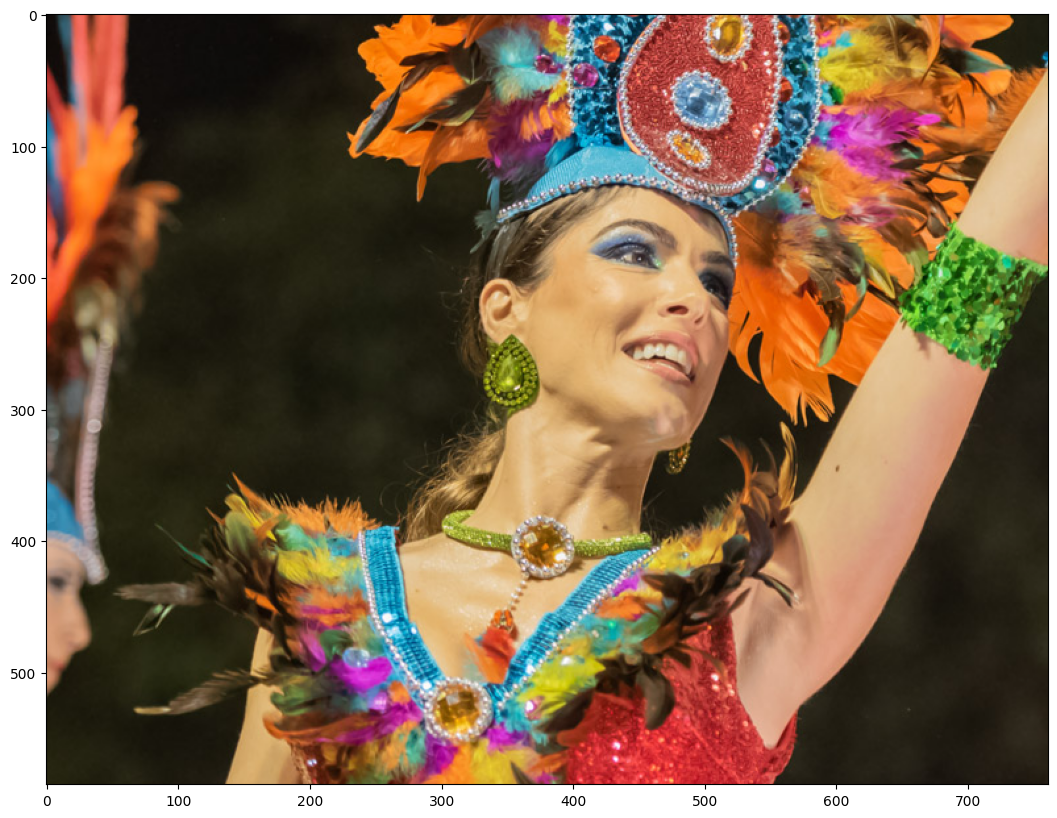

In [81]:
# Load image
img = cv2.imread('../data/222s.jpg')
# Convert it to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Plot it
plt.imshow(img)

Let's start with gray tones first.

In [82]:
# Black, dark gray, light gray, white
colors = np.array([[0, 0, 0],
                   [64, 64, 64],
                   [192, 192, 192],
                   [255, 255, 255]])

Using the colour pallette, let's quantize the original image.

In [83]:
# Cast the image to float
img = img.astype(np.float64)

# Prepare for quantization
rows, cols, channels = img.shape
quantized = np.zeros_like(img)

# Apply quantization
for r in range(rows):
    for c in range(cols):
        # Extract the original pixel value
        pixel = img[r, c]
        
        # Calculate the Euclidean distance between the pixel and each color in the palette
        distances = [np.linalg.norm(pixel - color) for color in colors]
            
        # Find the index of the closest color
        closest_color_index = np.argmin(distances)
            
        # Set the quantized pixel to the closest color
        new_pixel = colors[closest_color_index]

        # Apply quantization
        quantized[r, c, :] = new_pixel

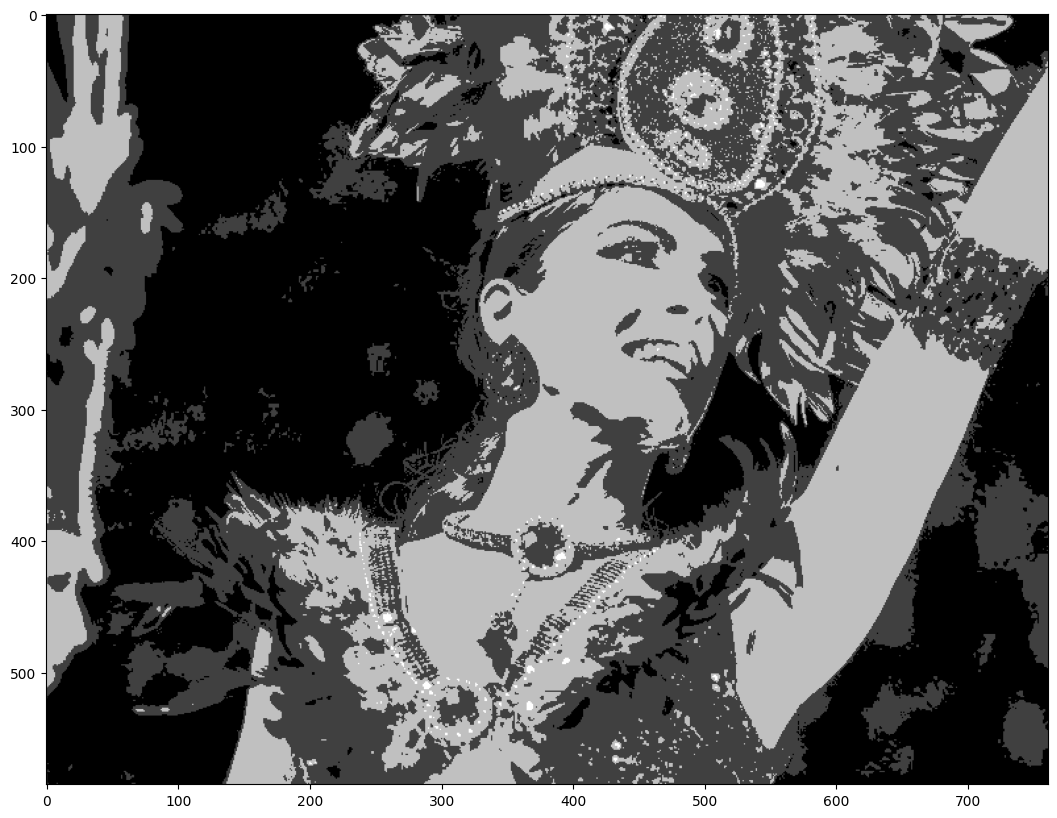

In [84]:
# Show quantized image (don't forget to cast back to uint8)
# img = img.astype(np.uint8)
quantized = quantized.astype(np.uint8)
plt.imshow(quantized)

In [85]:
# Compute PSNR
def psnr(ref, target):
    error = ref.astype(np.float32) - target.astype(np.float32)
    mse = np.mean(error**2)
    return 10 * np.log10((255**2)/mse)

# Compute SSIM
from skimage.metrics import structural_similarity
def ssim(original_image, transformed_image):
    # Convert images to grayscale by averaging RGB channels
    original_gray = np.mean(original_image, axis=2)
    transformed_gray = np.mean(transformed_image, axis=2)
    
    # Calculate SSIM between original and transformed images
    ssim_value = structural_similarity(original_gray, transformed_gray, data_range=transformed_gray.max() - transformed_gray.min())
    
    return ssim_value

print('PSNR', psnr(img.astype(np.uint8), quantized), 'dB')
print('SSIM', ssim(img.astype(np.uint8), quantized))

PSNR 14.13443 dB
SSIM 0.4096568035513576


#### Floyd-Steinberg Dithering
We are now going to implement the FS dithering and compare it to the optimally quantized image we have calculated above.

In [86]:
def quantize_image(image, palette):
    # Create an empty array for the quantized image
    quantized_image = np.zeros_like(image)
    
    # Get image dimensions
    rows, cols, _ = image.shape
    
    # Apply quantization
    for r in range(rows):
        for c in range(cols):
            # Extract the original pixel value
            pixel = image[r, c]
            
            # Calculate the Euclidean distance between the pixel and each color in the palette
            distances = [np.linalg.norm(pixel - color) for color in palette]
            
            # Find the index of the closest color
            closest_color_index = np.argmin(distances)
            
            # Set the quantized pixel to the closest color
            quantized_image[r, c, :] = palette[closest_color_index]
    
    return quantized_image

def floyd_steinberg_dithering(image, palette):
    # Make a temporal copy of the original image for error diffusion
    img_tmp = np.copy(image)
    dithering = np.zeros_like(image)
    
    # Get image dimensions
    rows, cols, _ = image.shape
    
    # Apply Floyd-Steinberg dithering
    for r in range(1, rows - 1):
        for c in range(1, cols - 1):
            # Extract the original pixel value
            pixel = img_tmp[r, c]
            
            # Calculate the Euclidean distance between the pixel and each color in the palette
            distances = [np.linalg.norm(pixel - color) for color in palette]
            
            # Find the index of the closest color
            closest_color_index = np.argmin(distances)
            
            # Set the quantized pixel to the closest color
            new_pixel = palette[closest_color_index]
            
            # Compute quantization error
            quant_error = pixel - new_pixel
            
            # Diffuse the quantization error according to the FS diffusion matrix
            img_tmp[r, c + 1] += quant_error * 7 / 16
            img_tmp[r + 1, c - 1] += quant_error * 3 / 16
            img_tmp[r + 1, c] += quant_error * 5 / 16
            img_tmp[r + 1, c + 1] += quant_error * 1 / 16
            
            # Apply dithering
            dithering[r, c, :] = new_pixel
    
    return dithering

quantized = quantize_image(img, colors).astype(np.uint8)
dithered = floyd_steinberg_dithering(img, colors).astype(np.uint8)

(<Axes: >, <matplotlib.image.AxesImage at 0x12420f440>)

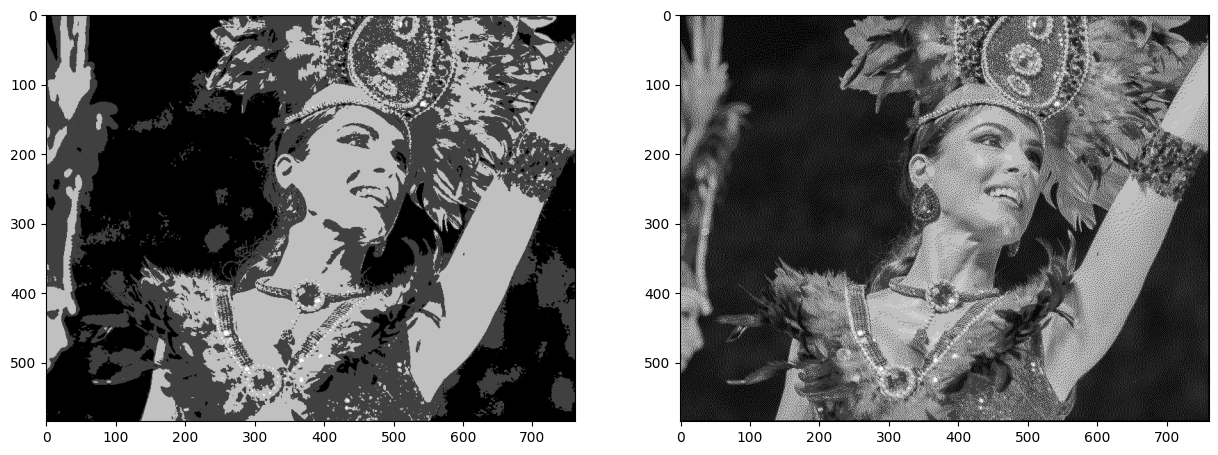

In [87]:
# Show quantized image (don't forget to cast back to uint8)
plt.subplot(121), plt.imshow(quantized)   # optimally quantized
plt.subplot(122), plt.imshow(dithered)   # dithering

In [88]:
# Compute PSNR and SSIM for dithered image
print('PSNR', psnr(img, dithered), 'dB')
print('SSIM', ssim(img, dithered))

PSNR 12.932213 dB
SSIM 0.21298255130757332


### Questions
* Which image has higher quantization error? Optimally quantized or dithered?

A: Quantized image has lower MSE (higher PSNR), than dithered.

* Which image looks better to you?

A: Dithered looks much better. What baffles me is that SSIM is also lower for dithered than quantized, although I expected it to be higher and closer to the subjective 'look quality'.

* Can you repeat the same process using only two colours: black and white? Show me :-)

A: Sure :)

Quantized PSNR 9.581591 dB
Quantized SSIM 0.21146842063354807
Dithered PSNR 7.150385 dB
Dithered SSIM 0.051075512083000256


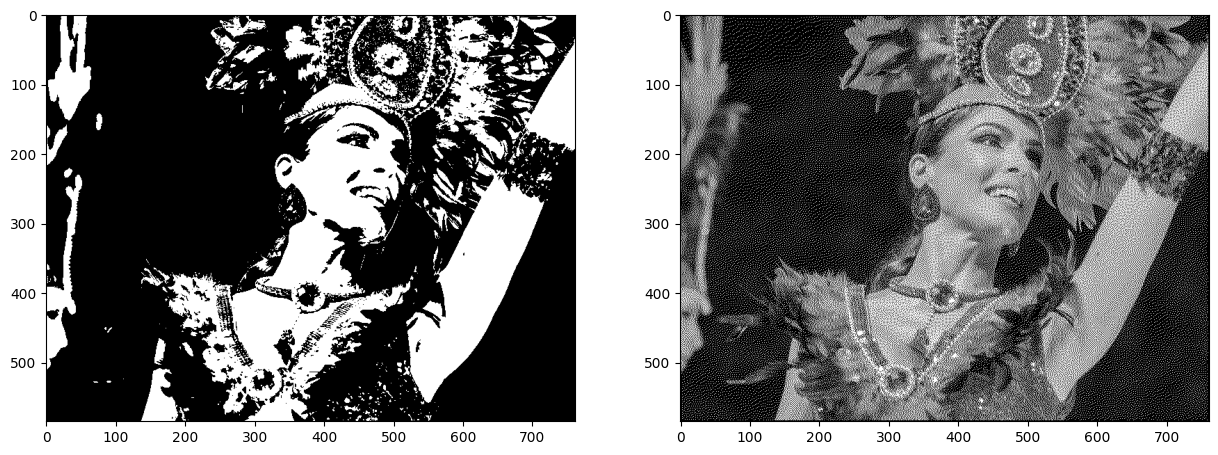

In [89]:
# BW palette
colors = np.array([[0, 0, 0],[255, 255, 255]])

quantized = quantize_image(img, colors).astype(np.uint8)
dithered = floyd_steinberg_dithering(img, colors).astype(np.uint8)

plt.subplot(121), plt.imshow(quantized)
plt.subplot(122), plt.imshow(dithered)

print('Quantized PSNR', psnr(img, quantized), 'dB')
print('Quantized SSIM', ssim(img, quantized))
print('Dithered PSNR', psnr(img, dithered), 'dB')
print('Dithered SSIM', ssim(img, dithered))

### Bonus Points

Repeat the homework using a diffrerent image pallette. For instance, you can use an optimal colour
pallette that we can calculate via k-means algorithm. The following snippet of code will give you the 16
optimal colours for your original image.

Quantized PSNR 24.696806 dB
Quantized SSIM 0.8339986209468925
Dithered PSNR 19.095123 dB
Dithered SSIM 0.584870825430658


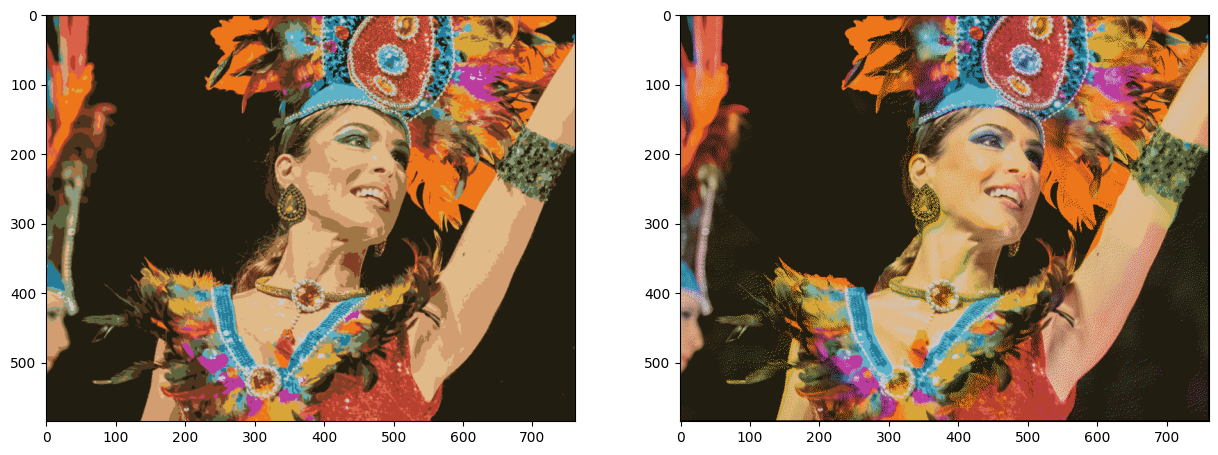

In [90]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=16).fit(np.reshape(img, (-1, 3)))
colors = kmeans.cluster_centers_

quantized = quantize_image(img, colors).astype(np.uint8)
dithered = floyd_steinberg_dithering(img, colors).astype(np.uint8)

plt.subplot(121), plt.imshow(quantized)
plt.subplot(122), plt.imshow(dithered)

print('Quantized PSNR', psnr(img, quantized), 'dB')
print('Quantized SSIM', ssim(img, quantized))
print('Dithered PSNR', psnr(img, dithered), 'dB')
print('Dithered SSIM', ssim(img, dithered))

Apply FS dithering the same way you did before.
* How does the result look like to you?

A: Much better than in BW :)

* What happens if we use 32 colours?

A: Obviously the more colors we use in out palette the higher quality quantized and dithered images we will get, and also the longer our ineffective implementation will take to compute.

* And what happens if we use 256 colours?

A: Our nested for-loops work for excruciatingly long 4 minutes (should have used cdist instead ;)), but as a result dithered image looks almost indistinguishable from the original for me.